# Solvice OnStock long form notebook

### Description

This coding guide offers the reader multiple insights: it introduces the Multi Echelon Inventory Optimization (MEIO) problem, while exploring different scenarios. This includes a comparison between a base stock policy approach and the RQ policy. Moreover, it illustrates how the user can expect to have full control over the request settings and get a response with all the necessary information.

OnStock offers solutions for multi echelon planning. Here, the supply chain network is seen as a whole. It is different from the single echelon approximation that looks at nodes separately. Our solver decides how much stock should be carried and where it should be placed. To get a better grip on what these drivers are, we'll first introduce some core concepts for the Guaranteed Service approach.

Complementary resources for this notebook are:

-the guide, starting at https://docs.solvice.io/docs/onstock-overview

-the API reference, at https://docs.solvice.io/reference/solve-2

Contact in case of any questions: support@solvice.io

### The Guaranteed Service Model (GSM)
The Guaranteed Service Model considers the processing times and the demands in a supply network as deterministic. 

Goods in any Supply Chain network move towards a customer. We present a supply chain as an acyclic graph that consists of nodes and directed edges. A node can be any kind of retail outlet, warehouse (for storing purposes, as a hub to distribute towards the final customer...), a working station at a plant (to add value to a product, for instance by assembling parts of a vehicle or quality testing them...) or any processing station. An edge is any existing connection between two nodes, indicating that goods can flow between them.

In the simple assembly network below, we notice that Parts A and B converge into one sub assembly node. The newly created  intermediary at 'Sub assembly' is then combined with 'Part C' at the Final assembly. Below this figure, we construct a request that models this network structure according to the specifications of our OnStock API. 


Simple assembly network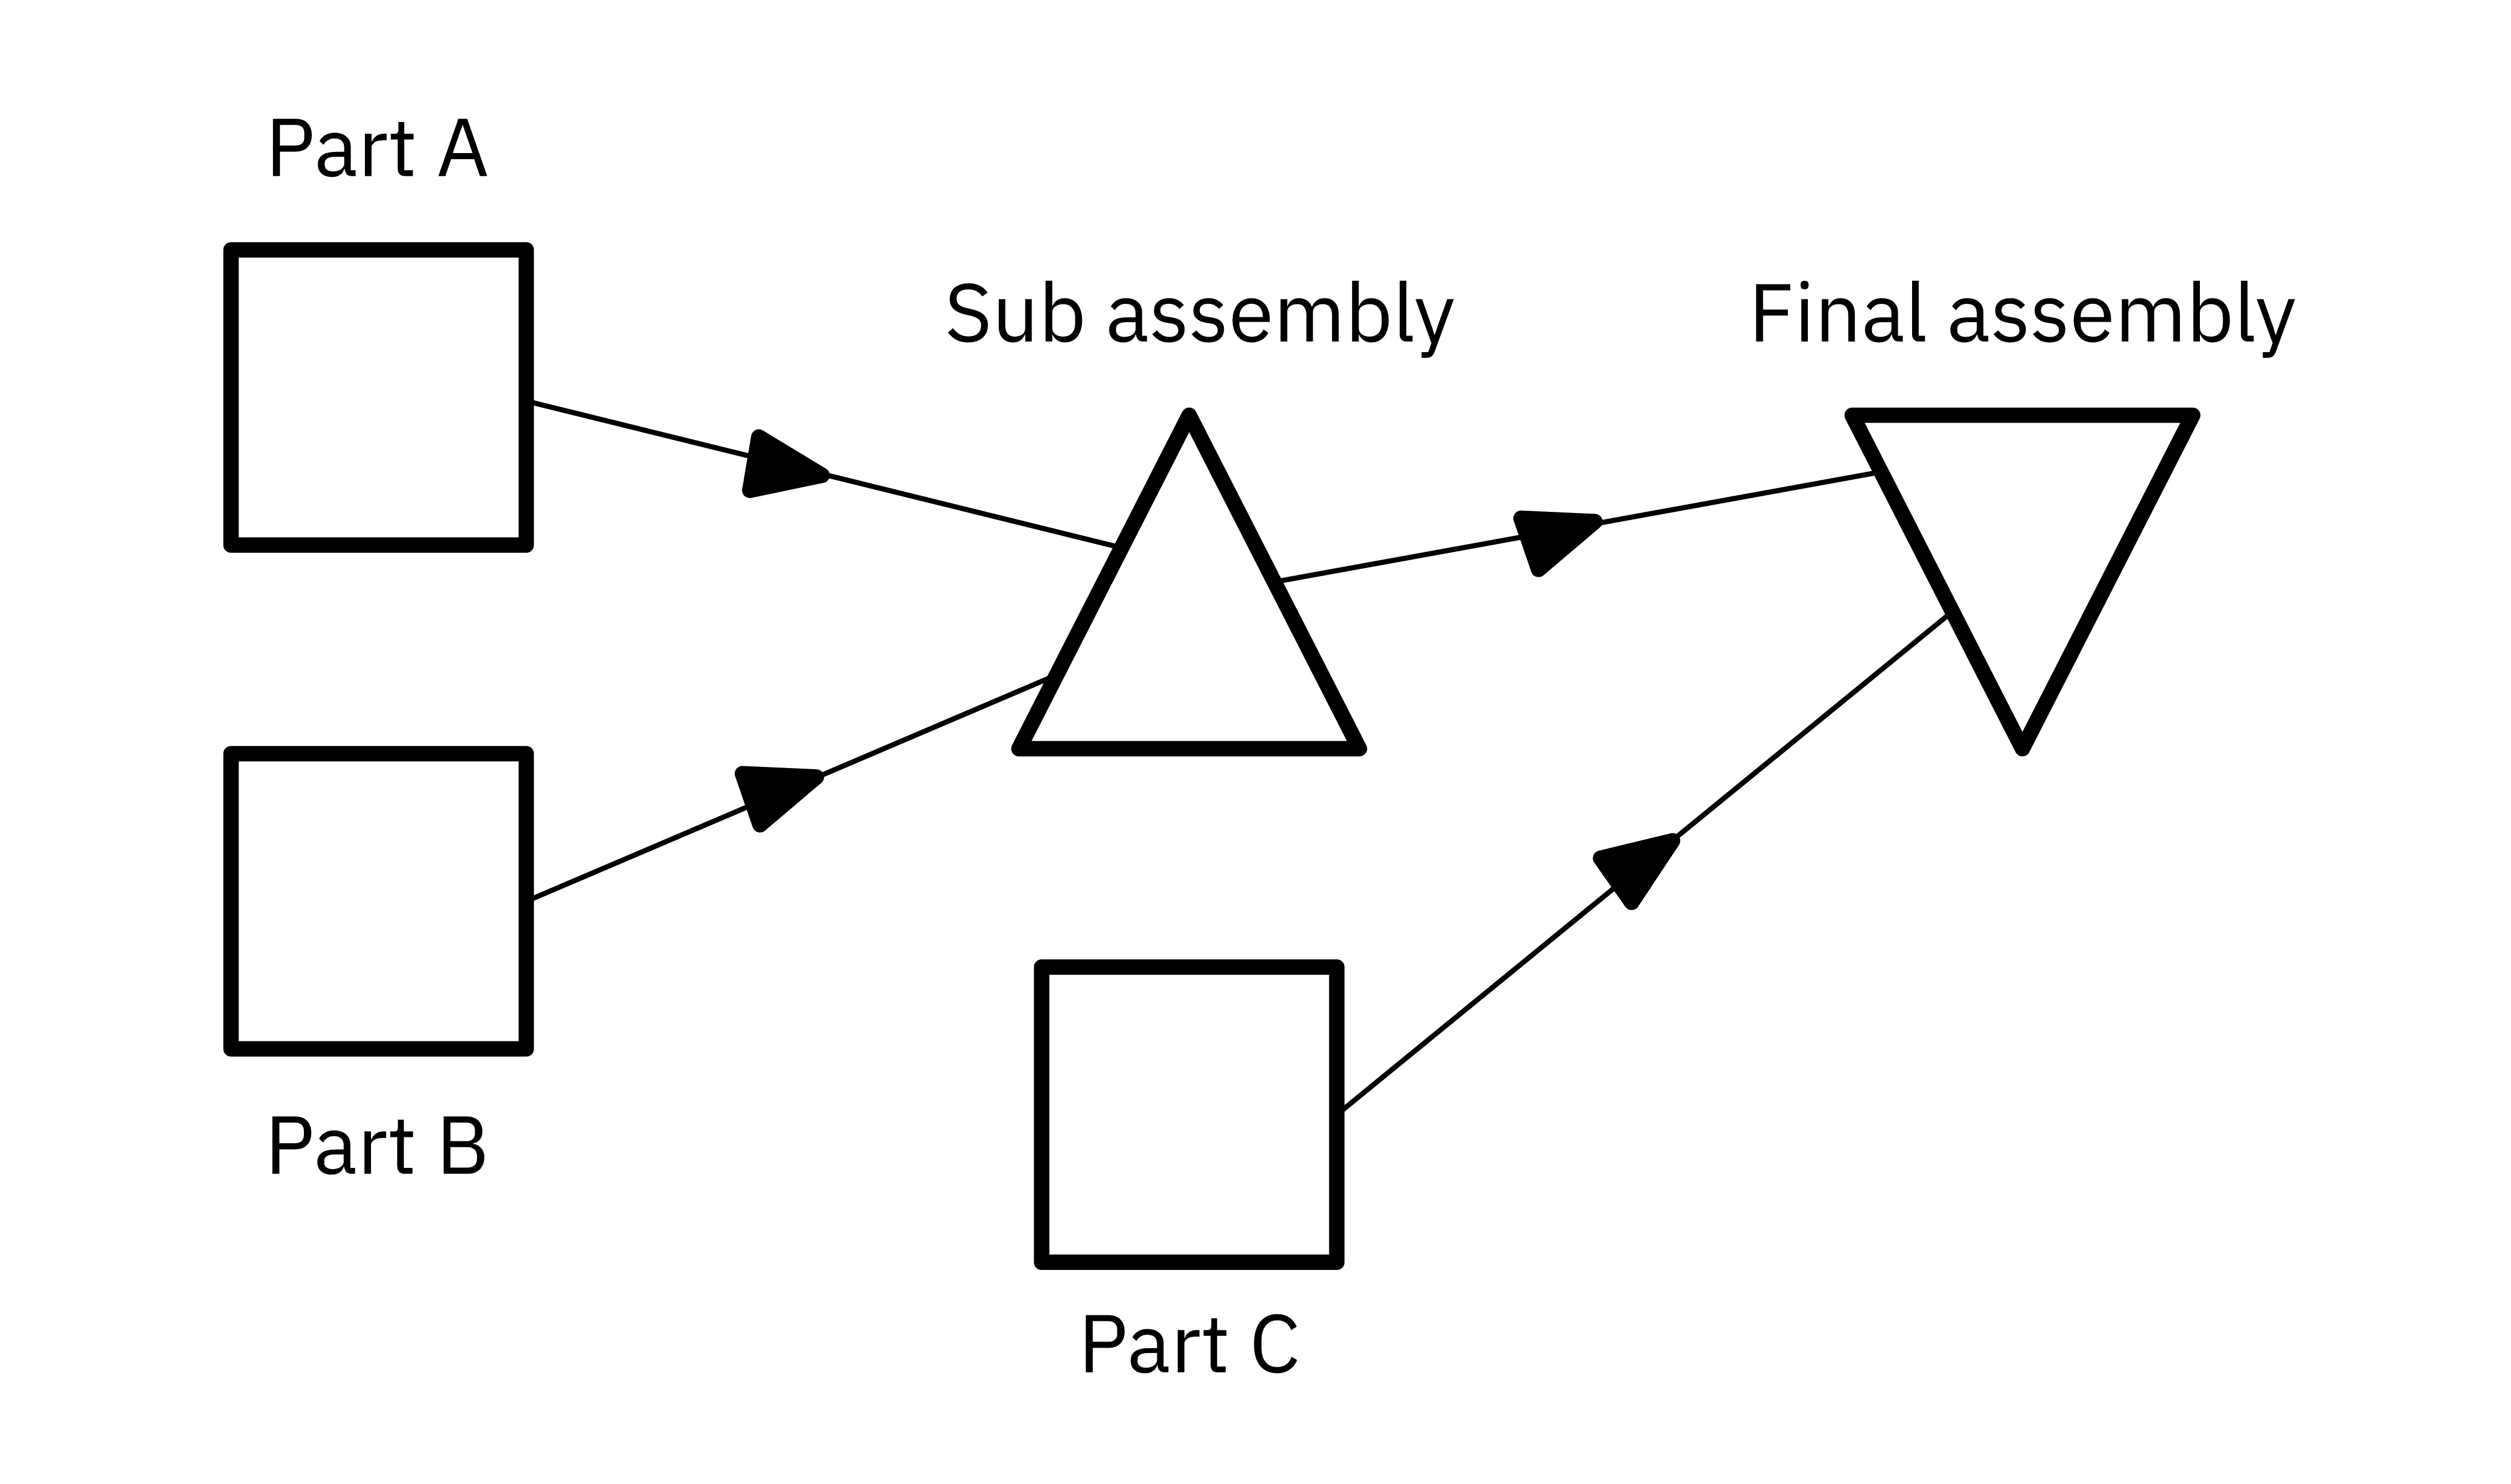

### First OnStock request

We start off by creating a Node class that contains all node parameters we want to communicate to the API. The iter method is used for parameter name changing during dictionary transformation of an object. Dictionaries are later on transformed to the json format, which the API digests. Note that camelCase and snake_case are used interchangeably - in this notebook, we'll use snake_case for internal variables, but we also have to respect the camelCase form for the API.

Let's take a look at the info we include in this type of object.

The OnStock API solver decides on where to keep stock and how much. We can think of three critical time indicators per node: how long it takes for a good to arrive from the upstream part of the network (incomingServiceTime), how long it takes to process something after it has arrived (nominalTime) and the time a node quotes to all of his downstream nodes (outgoingServiceTime). Of these three, the nominalTime is a fixed value we feed to the API (nominal_time in code). These three times are related by tau, an important internal parameter for OnStock. For more technical detail, checking the guide is advised.

For the total cost of an (intermediary) product, we take into account all the previous processing steps that the product has undergone (cost), resulting in the cumulativeCost that will appear later on. Then, we'll multiply this with the holdingRate to get the unit holding cost. Serving all possible demand 100% of the time is infeasible - a network would need an infinite amount of stock for that. To make sure we're working on a bounded problem, we define a serviceLevel per node.

(For further explanation about these parameter and options, you can always check the resources mentioned in the beginning. We'll also demonstrate how to use the demo endpoint in a bit, which will clarify the structure.)

In [ ]:
class Node:

    def __init__(self, name, nominal_time, cost, service_level):
        self.name = name
        self.successors = list()
        self.nominal_time = nominal_time
        self.cost = cost
        self.service_level = service_level

    avg_customer_demand = None
    sd_customer_demand = None

    def __iter__(self):
        yield 'name', self.name
        yield 'nominalTime', self.nominal_time
        yield 'cost', self.cost
        yield 'successors', self.successors
        yield 'serviceLevel', self.service_level
        if self.avg_customer_demand is not None: yield 'avgCustomerDemand', self.avg_customer_demand
        if self.sd_customer_demand is not None: yield 'sdCustomerDemand', self.sd_customer_demand

In the next block, we'll construct the network nodes. The construction parameters hereunder are consistent with those in the guide linked on top.

We choose to set service_level at 90% (0.9) for all nodes. Based on these inputs, the OnStock solver calculates the corresponding safety stock values to make sure that the asked demand is met.

We only define the demand parameters for the client node. For other nodes, OnStock propagates all values automatically. Also note that the successors are consistent with the figure above.

In [ ]:
node_part_A = Node("Part A", nominal_time=2, cost=1, service_level=0.9)
node_part_B = Node("Part B", nominal_time=2, cost=1, service_level=0.9)
node_part_C = Node("Part C", nominal_time=3, cost=1, service_level=0.9)
node_sub_assembly = Node("Sub Assembly", nominal_time=1, cost=4, service_level=0.9)
node_final_assembly = Node("Final Assembly", nominal_time=2, cost=5, service_level=0.9)

# In this model, demand propagates from customer nodes into the network
# No demand would mean no stock
node_final_assembly.avg_customer_demand = 52000
node_final_assembly.sd_customer_demand = 3000

# Construct the network, using names as reference. 
# It's important that in the request, a node is declared before its name is referenced
# We'll remind you in the next code cell (node_list)
node_part_A.successors.extend({node_sub_assembly.name}) # Part A -> Sub assembly
node_part_B.successors.extend({node_sub_assembly.name}) # Part B -> Sub assembly
node_sub_assembly.successors.extend({node_final_assembly.name}) # Sub assembly -> Final assembly
node_part_C.successors.extend({node_final_assembly.name})# Part C -> Final assembly

We use the demo endpoint to retrieve base_stock_json, in which we'll replace the networkNodes of the demo json structure by the ones we just created. It's important to declare a node before it can be referred to as a successor, hence the sequence of node_list.

In [ ]:
# get your free API key at https://dashboard.solvice.io/
auth = ""

In [ ]:
import json
import requests

# use the demo endpoint so we have a standard structure to start from
header_keys = {"Authorization": auth, "Content-Type" : "application/json", "Accept" : "application/json"}
url = "https://api.solvice.io/demo/stock/base"
base_stock_response = requests.get(url, headers=header_keys)
base_stock_json = base_stock_response.json()

# a node should be defined before we can refer to it, so we go from right to left (see figure)
node_list = [node_final_assembly,
             node_sub_assembly, node_part_A, node_part_B,
             node_part_C]

created_network_nodes = list(map(dict, node_list))

base_stock_json['networkNodes'] = created_network_nodes
base_stock_json

### First OnStock response
In this part, we use another Solvice endpoint to solve our request for 5 seconds. The API works asynchronously: the first response will contain a job id. Using this id, we're able to retrieve the solution. If OnStock is done calculating, the 'status' field of the response of get_job will be 'SOLVED'.

In [ ]:
import time 
solve_time = 5
latency = 1

# solve the request on the Solvice API, endpoints resolves a response to the job_id
url = "https://api.solvice.io/solve?seconds={}".format(solve_time)
job_id = requests.post(url, headers=header_keys, json=base_stock_json).json()['id']
time.sleep(solve_time + latency)

In [ ]:
url = "https://api.solvice.io/jobs/{}".format(job_id)
response = requests.get(url, headers=header_keys)

# print the response code
print("Response code {}".format(response.status_code))
response_body = response.json()

if not response_body['status'] == 'SOLVED': print("Job is not solved yet, please re-run cell. \nCheck https://dashboard.solvice.io/jobs/logs for a browser view.")
    
response_body

Let’s focus on the score of the response. The fact that hardScore and mediumScore are equal to zero means that no constraints were broken. The softScore corresponds to the total yearly cost for keeping safety stock in your network. The origin of this cost can be found in another part of the response body under 'unresolved'.

In [ ]:
response_body['score']['softScore']

## Why MEIO?

### Single echelon request and response

The argument is pretty quick. Let's feed a single echelon configuration to the solver. Since stages are agnostic of each other's stock keeping, this implies that at any point in time, any stage must be able to fulfill demand with a certain serviceLevel immediately! It suffices to only set outgoingServiceTime to zero to mimic this behaviour.

In the same way we fed Nodes to OnStock, here, we construct a list of ServiceTimeAssignments.
The API is able to construct a solution and evaluate it based on this data. (The technical reason is that outgoingServiceTime is the only decision variable per node for the base stock problem)

In [ ]:
class ServiceTimeAssignment:

    def __init__(self, node_id, node, outgoing_service_time=0):
        self.node_id = node_id
        self.node = node
        self.outgoing_service_time = outgoing_service_time

    def __iter__(self):
        yield 'id', self.node_id
        yield 'node', self.node
        yield 'outgoingServiceTime', self.outgoing_service_time

In [ ]:
# create service time assignments with outgoing service time equal to zero (default parameters, see constructor above)

service_time_assignment_list = list()

# we create instances that have the required data for the API:
# an id, the node name and outgoing_service_time (0 by default)
for i, node in enumerate(node_list):
    service_time_assignment_list.append(dict(ServiceTimeAssignment(i, node.name)))

# create a copy of the original request and plug in our own ServiceTimeAssignments
base_stock_single_echelon_json = base_stock_json.copy()
base_stock_single_echelon_json['serviceTimeAssignments'] = service_time_assignment_list

The request below is based on the original one. We evaluate the solution that represents a single echelon approach by using the Solvice evaluate endpoint to retrieve the id of the job, analogous to how we contacted the solve endpoint. Afterwards, we'll get the calculation result using get_job and compare the score.

In [ ]:
# solve the single echelon request on the Solvice API
url = "https://api.solvice.io/evaluate"
job_id = requests.post(url, headers=header_keys, json=base_stock_single_echelon_json).json()['id']
time.sleep(latency)

In [ ]:
url = "https://api.solvice.io/jobs/{}".format(job_id)
response_single_echelon = requests.get(url, headers=header_keys)

# print the response code and body
print("Response code {}".format(response_single_echelon.status_code))
response_single_echelon_body = response_single_echelon.json()

if not response_single_echelon_body['status'] == 'SOLVED': print("Job is not solved yet, please re-run cell. \nCheck https://dashboard.solvice.io/jobs/logs for a browser view.")
    
response_single_echelon_body

In [ ]:
print("Single echelon cost: " + str(response_single_echelon_body['score']['softScore']))
print("Multi echelon cost: " + str(response_body['score']['softScore']))

In [ ]:
def get_safety_stock_at_node(solution, name):
    node_solution = list(filter(lambda el: el['node'] == name, solution))[0]
    return node_solution['safetyStock']

single_final_assembly_solution = get_safety_stock_at_node(response_single_echelon_body['solution'], "Final Assembly")
single_sub_assembly_solution = get_safety_stock_at_node(response_single_echelon_body['solution'], "Sub Assembly")
single_part_c_solution = get_safety_stock_at_node(response_single_echelon_body['solution'], "Part C")

multi_final_assembly_solution = get_safety_stock_at_node(response_body['solution'], "Final Assembly")
multi_sub_assembly_solution = get_safety_stock_at_node(response_body['solution'], "Sub Assembly")
multi_part_c_solution = get_safety_stock_at_node(response_body['solution'], "Part C")

print("Safety stock keeping")
print("Final assembly:\t single echelon {} vs multi echelon {}".format(single_final_assembly_solution, multi_final_assembly_solution))
print("Sub assembly:\t single echelon {} vs multi echelon {}".format(single_sub_assembly_solution, multi_sub_assembly_solution))
print("Part C:\t\t single echelon {} vs multi echelon {}".format(single_part_c_solution, multi_part_c_solution))

### Conclusion base stock MEIO versus single echelon

We notice an increase in cost for the single echelon approach. Seeing the network as a whole, OnStock decided to put more stock at ‘Final assembly’ because this is compensated greatly by being able to keep less stock at ‘Sub assembly’ and ‘Part C’.

## The RQ policy

### An RQ extended request and response

We obtained the first results using the Base Stock policy. We remember that MEIO is about minimising total cost - but are we taking everything into account when only optimising for base stock?

In reality, we see that another important driver is the cost that stems from ordering goods. When we don't define a fixed order batch size, which we will call Q from this point on, the policy can get expensive with regards to ordering cost. When only taking into account a base stock level, which should be replenished to the same replenishment point R again every time, the amount ordered per time unit is very variable. This can get very expensive because of overhead administration and repacking. Sometimes it might not even be possible to order a certain non-round number Q in reality. Then, the Base Stock model definitely falls short, because the only way to reach the base level is by overshooting it. This implies keeping more stock than is accounted for in the total holding cost.

For a demonstration of the RQ policy, we will use the same network as before. For every node, we introduce an ordering cost (fixedOrderCost), a step by which the ordering batch size Q can increase (orderSizeStep) and a maximum value for Q (orderSizeMax). The orderSizeStep parameter together with the orderSizeMax defines the values of Q that can be chosen. It is not possible to choose an orderSizeStep that is larger than an orderSizeMax, and if orderSizeMax is not a whole multiple of orderSizeStep, the OnStock solver will round the actual maximum value down to the largest whole multiple of orderSizeStep that is smaller than orderSizeMax.

It is important to note that the chosen value for Q is not always how much a node will order when it falls below its base stock. An actual order in reality will consist of a whole multiple of batches of size Q, more specifically the least multiple that compensates the stock level enough so that it is larger than the base stock level. Example: if R is 40, Q is 10 and stock falls down to 25, the order will consist of 20 pieces (25 + 2 batches * 10/batch > 40, 1 batch is not enough and 3 is too many since 2 already suffices).

We extend the first OnStock request. Note that the solver parameter in the request changes from BASE_STOCK to RQ_STOCK. The structure of the code is analogous to that of our first request.

In [ ]:
class RQNode:

    def __init__(self, name, nominal_time, cost, order_size_step, fixed_order_cost, service_level=0.9,  order_size_max=5000):
        self.name = name
        self.successors = list()
        self.nominal_time = nominal_time
        self.cost = cost
        self.service_level = service_level
        self.order_size_step = order_size_step
        self.order_size_max = order_size_max
        self.fixed_order_cost = fixed_order_cost

    avg_customer_demand = None
    sd_customer_demand = None

    def __iter__(self):
        yield 'name', self.name
        yield 'nominalTime', self.nominal_time
        yield 'cost', self.cost
        yield 'successors', self.successors
        yield 'serviceLevel', self.service_level
        yield 'orderSizeStep', self.order_size_step
        yield 'orderSizeMax', self.order_size_max
        yield 'fixedOrderCost', self.fixed_order_cost
        if self.avg_customer_demand is not None: yield 'avgCustomerDemand', self.avg_customer_demand
        if self.sd_customer_demand is not None: yield 'sdCustomerDemand', self.sd_customer_demand

In [ ]:
rq_node_part_A = RQNode("Part A", nominal_time=2, cost=1, order_size_step=600, fixed_order_cost=0.2)
rq_node_part_B = RQNode("Part B", nominal_time=2, cost=1, order_size_step=600, fixed_order_cost=0.1)
rq_node_part_C = RQNode("Part C", nominal_time=3, cost=1, order_size_step=400, fixed_order_cost=0.1)
rq_node_sub_assembly = RQNode("Sub Assembly", nominal_time=1, cost=4, order_size_step=200, fixed_order_cost=0.3)
rq_node_final_assembly = RQNode("Final Assembly", nominal_time=2, cost=5, order_size_step=200, fixed_order_cost=0.5)

rq_node_final_assembly.avg_customer_demand = 52000
rq_node_final_assembly.sd_customer_demand = 3000

rq_node_part_A.successors.extend({rq_node_sub_assembly.name})
rq_node_part_B.successors.extend({rq_node_sub_assembly.name})
rq_node_sub_assembly.successors.extend({rq_node_final_assembly.name})
rq_node_part_C.successors.extend({rq_node_final_assembly.name})

In [ ]:
# a node should be defined before we can refer to it, so we go from right to left (see figure)
rq_node_list = [rq_node_final_assembly,
                rq_node_sub_assembly, rq_node_part_A, rq_node_part_B,
                rq_node_part_C]

created_network_rq_nodes = list(map(dict, rq_node_list))

rq_stock_json = base_stock_json.copy()

# change solver to RQ_STOCK
rq_stock_json['solver'] = 'RQ_STOCK'
rq_stock_json['networkNodes'] = created_network_rq_nodes

# solve the request on the Solvice API
url = "https://api.solvice.io/solve?seconds={}".format(solve_time)
job_id = requests.post(url, headers=header_keys, json=rq_stock_json).json()['id']
time.sleep(solve_time + latency)

In [ ]:
url = "https://api.solvice.io/jobs/{}".format(job_id)
response = requests.get(url, headers=header_keys)

# print the response code and body
print("Response code {}".format(response.status_code))
rq_response_body = response.json()

if not rq_response_body['status'] == 'SOLVED': print("Job is not solved yet, please re-run cell. \nCheck https://dashboard.solvice.io/jobs/logs for a browser view.")

rq_response_body

In [ ]:
print("New total cost")
print(rq_response_body['score']['softScore'])
print("Old total cost")
print(response_body['score']['softScore'])
print("New Inventory Holding Cost")
print(list(filter(lambda el: el['name'] == 'Inventory Holding Cost related to the safety stock', rq_response_body['unresolved']))[0]['value'])

This score is higher than our first result, but on further inspection of the score object, we see that Inventory Holding Cost is exactly the same. This is not surprising, since the RQ problem can be decomposed in the base stock problem and the Q problem. The other two scores are specific to Q: the ordering cost and the extra incurred holding cost because of order size batching. The RQ-solution body also contains orderSizeAssignments, which are the choices made for Q per node, as well as an extended solution object.

## Choosing minimal Q

To illustrate the importance of choosing good values for Q, we will evaluate a solution which uses the same ServiceTimeAssignments, but chooses the lowest Q value per node.

We construct OrderSizeAssignments and plug them into the evaluation request, analogous to the steps we undertook for the single echelon evaluation.

In [ ]:
class OrderSizeAssignment:

    def __init__(self, node_id, node, order_size):
        self.node_id = node_id
        self.node = node
        self.order_size = order_size

    def __iter__(self):
        yield 'id', self.node_id
        yield 'node', self.node
        yield 'orderSize', self.order_size

In [ ]:
rq_minimal_q_json = rq_stock_json.copy()
rq_minimal_q_json['serviceTimeAssignments'] = rq_response_body['serviceTimeAssignments']

# create order size assignments with order size equal to minimal size

order_size_assignment_list = list()

# we create instances that have the required data for the API:
# an id, the node name and order size
for i, node in enumerate(rq_node_list):
    order_size_assignment_list.append(dict(OrderSizeAssignment(i, node.name, node.order_size_step)))

rq_minimal_q_json['orderSizeAssignments'] = order_size_assignment_list

In [ ]:
# evaluate using Solvice endpoints
url = "https://api.solvice.io/evaluate"
job_id = requests.post(url, headers=header_keys, json=rq_minimal_q_json).json()['id']
time.sleep(latency)

In [ ]:
url = "https://api.solvice.io/jobs/{}".format(job_id)
response = requests.get(url, headers=header_keys)

# print the response code and body
print("Response code {}".format(response.status_code))
response_body_minimal_q = response.json()

if not response_body_minimal_q['status'] == 'SOLVED': print("Job is not solved yet, please re-run cell. \nCheck https://dashboard.solvice.io/jobs/logs for a browser view.")

response_body_minimal_q

### Conclusion RQ Policy

Choosing smaller batch sizes drives down the inventory cost related to Q, but it drives up the ordering cost. The solver will balance these out when RQ_STOCK is selected to reach the smallest total cost.
Since we know that picking the smallest batch size is an assumption of the base stock policy, we conclude that the RQ policy offers potential large cost cuts.

In [ ]:
print("Inventory cost (Q) for:")
print("-smallest order size: \t" + str(list(filter(lambda el: el['name'] == 'Inventory Holding Cost related to the order quantity', response_body_minimal_q['unresolved']))[0]['value']))
print("-optimised order size: \t" + str(list(filter(lambda el: el['name'] == 'Inventory Holding Cost related to the order quantity', rq_response_body['unresolved']))[0]['value']))
print()
print("Node ordering cost for:")
print("-smallest order size: \t" + str(list(filter(lambda el: el['name'] == 'Node Ordering Cost', response_body_minimal_q['unresolved']))[0]['value']))
print("-optimised order size: \t" + str(list(filter(lambda el: el['name'] == 'Node Ordering Cost', rq_response_body['unresolved']))[0]['value']))
print()
print("Total cost for:")
print("-smallest order size: \t" + str(response_body_minimal_q['score']['softScore']))
print("-optimised order size: \t" + str(rq_response_body['score']['softScore']))

***That's it, congratulations!***

Reminder that the compatible resources for this notebook are:

-the guide, starting at https://docs.solvice.io/docs/onstock-overview

-the API reference, at https://docs.solvice.io/reference/solve-2

Contact in case of any questions: support@solvice.io